In [45]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import pickle
import torch.nn as nn
import gymnasium as gym
import torch.nn.functional as F
import torch.optim as optim
from collections import deque

In [46]:
X_test = np.load('../Data/X_test.npy')
y_test = np.load('../Data/y_test.npy')

In [47]:
with open('../Data/vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

Initialisation de l'agent

In [48]:
class DQNAgent:
    """Agent utilisant un DQN avec replay memory et exploration epsilon-greedy"""
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001

        self.model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.criterion = nn.MSELoss()
        
        self.losses = []
        self.rewards = []
        self.epsilons = []
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
    
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        
        with torch.no_grad():
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            act_values = self.model(state_tensor)
            return torch.argmax(act_values[0]).item()
    
    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return 0
        
        minibatch = random.sample(self.memory, batch_size)
        total_loss = 0
        
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            
            target = reward
            if not done:
                with torch.no_grad():
                    target = reward + self.gamma * torch.max(self.model(next_state_tensor)[0]).item()
            
            current_q = self.model(state_tensor)[0]
            target_f = current_q.clone()
            target_f[action] = target
            
            self.optimizer.zero_grad()
            loss = self.criterion(current_q, target_f)
            loss.backward()
            self.optimizer.step()
            
            total_loss += loss.item()
        
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
            
        avg_loss = total_loss / batch_size
        self.losses.append(avg_loss)
        return avg_loss
    
    def plot_metrics(self):
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
        
        ax1.plot(self.losses)
        ax1.set_title('Évolution de la perte pendant l\'entraînement')
        ax1.set_xlabel('Mini-batch')
        ax1.set_ylabel('Perte (MSE)')
        ax1.grid(True)
        
        ax2.plot(self.epsilons, label='Epsilon')
        if self.rewards:
            window_size = min(50, len(self.rewards))
            smoothed_rewards = np.convolve(self.rewards, np.ones(window_size)/window_size, mode='valid')
            ax2.plot(smoothed_rewards, label='Récompense moyenne (lissée)')
        
        ax2.set_title('Évolution de l\'exploration et des récompenses')
        ax2.set_xlabel('Épisode')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.savefig('../Data/training_metrics.png')
        plt.show()
    
    def load(self, name):
        self.model.load_state_dict(torch.load(name))
    
    def save(self, name):
        torch.save(self.model.state_dict(), name)

In [49]:
class DQN(nn.Module):
    """Réseau de neurones pour l'apprentissage Q (Deep Q-Network)"""
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, output_dim)
        
        nn.init.kaiming_normal_(self.fc1.weight)
        nn.init.kaiming_normal_(self.fc2.weight)
        nn.init.kaiming_normal_(self.fc3.weight)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [50]:
state_size = X_test.shape[1]
action_size = 2
agent = DQNAgent(state_size, action_size)
agent.load('../Data/fake_job_dqn_model.pth')

Évaluation du modèle sur l'ensemble de test

In [51]:
y_pred = []
q_values_list = []
with torch.no_grad():
    for i in range(len(X_test)):
        state = X_test[i].astype(np.float32)
        state_tensor = torch.FloatTensor(state).unsqueeze(0)
        q_values = agent.model(state_tensor)
        action = torch.argmax(q_values[0]).item()
        y_pred.append(action)
        q_values_list.append(q_values[0].numpy())

Calcul des métriques

In [52]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Précision: {accuracy:.4f}")
print("\nRapport de classification:")
print(classification_report(y_test, y_pred))

Précision: 0.9592

Rapport de classification:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3403
           1       0.91      0.17      0.29       173

    accuracy                           0.96      3576
   macro avg       0.93      0.59      0.64      3576
weighted avg       0.96      0.96      0.95      3576



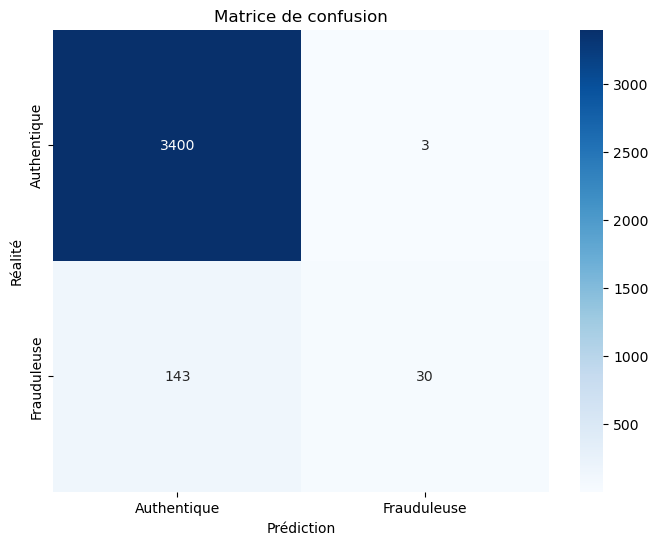

In [53]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Authentique', 'Frauduleuse'],
            yticklabels=['Authentique', 'Frauduleuse'])
plt.xlabel('Prédiction')
plt.ylabel('Réalité')
plt.title('Matrice de confusion')
plt.savefig('../Data/final_confusion_matrix.png')
plt.show()

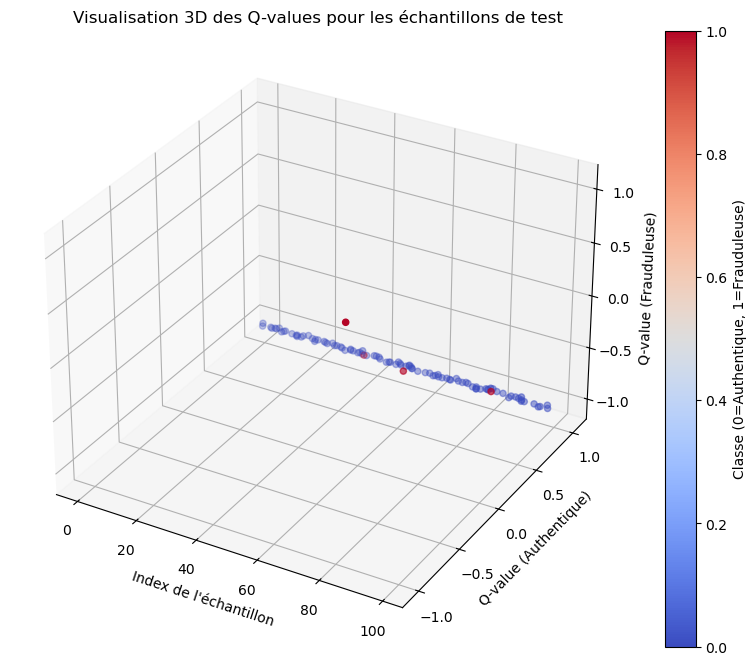

In [54]:
plt.ion()
sample_size = min(100, len(X_test))
q_values_sample = np.array(q_values_list[:sample_size])
indices = np.arange(sample_size)
q_real = q_values_sample[:, 0]
q_fake = q_values_sample[:, 1]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(indices, q_real, q_fake, c=y_test[:sample_size], cmap='coolwarm', marker='o')

ax.set_xlabel('Index de l\'échantillon')
ax.set_ylabel('Q-value (Authentique)')
ax.set_zlabel('Q-value (Frauduleuse)')
ax.set_title('Visualisation 3D des Q-values pour les échantillons de test')

cbar = plt.colorbar(scatter)
cbar.set_label('Classe (0=Authentique, 1=Frauduleuse)')
plt.savefig('../Data/q_values_3d.png')
plt.show(block=False)

Test sur une nouvelle offre d'emploi